#Churn Analysis For A Telco Company

Importing the necessary libraries

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN

Datatset

In [16]:
telco_base_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Top 5 records of data

In [17]:
telco_base_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Shape of Dataset

In [18]:
telco_base_data.shape

(7043, 21)

Column Names

In [19]:
telco_base_data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

Data Types

In [20]:
telco_base_data.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


Descriptive Statistics

In [21]:
telco_base_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000



* SeniorCitizen is actually a categorical hence the 25%-50%-75% distribution is not proper

* 75% customers have tenure less than 55 months.

* Average Monthly charges are USD 64.76 whereas 25% customers pay more than USD 89.85 per month.

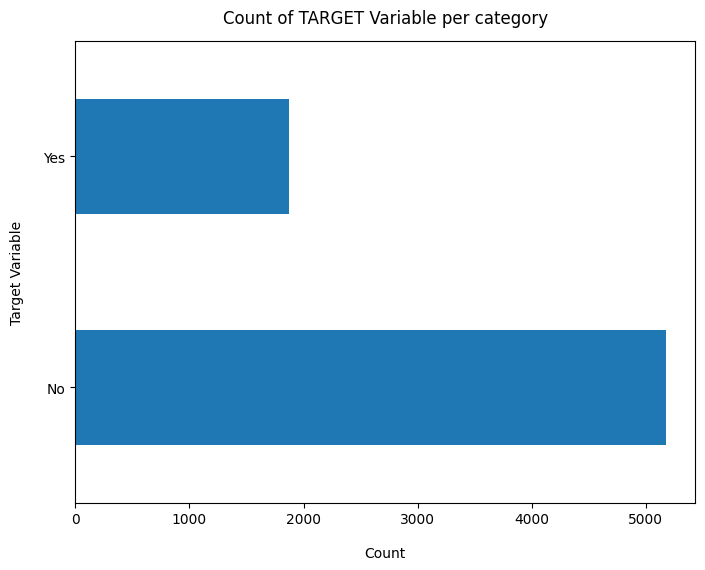

In [22]:
telco_base_data['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [23]:
100*telco_base_data['Churn'].value_counts()/len(telco_base_data['Churn'])

,count
Churn,
No,73.463013
Yes,26.536987


In [24]:
telco_base_data['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


* Data is highly imbalanced, ratio = 73:27<br>
* So we analyse the data with other features while taking the target values separately to get some insights.

Summary of dataframe

In [25]:
telco_base_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


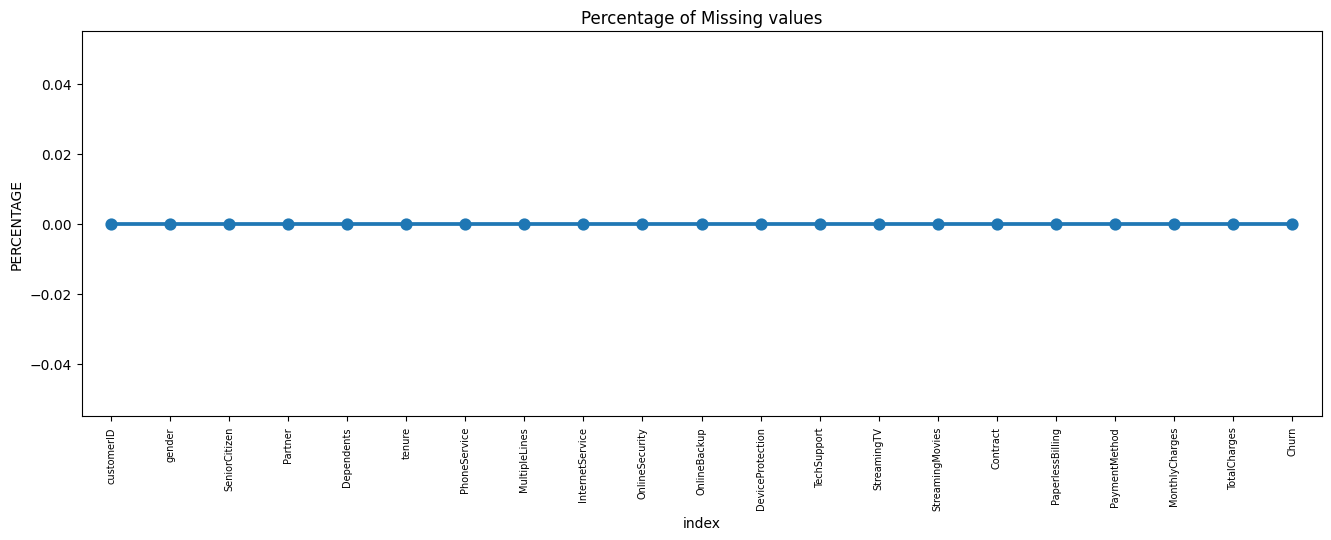

In [26]:
missing = pd.DataFrame((telco_base_data.isnull().sum())*100/telco_base_data.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index',y=0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

* Here, we don't have any missing data.

## Data Cleaning


Creating a copy of base data for manupulation & processing

In [27]:
telco_data = telco_base_data.copy()

Total Charges should be numeric amount.

In [28]:
telco_data.TotalCharges = pd.to_numeric(telco_data.TotalCharges, errors='coerce')
telco_data.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


As we can see there are 11 missing values in TotalCharges column.

In [29]:
telco_data.loc[telco_data ['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Since the % of these records compared to total dataset is very low ie 0.15%, it is safe to ignore them from further processing.

In [30]:
#Removing missing values
telco_data.dropna(how = 'any', inplace = True)

Dividing customers into bins based on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [31]:
#Getting the max tenure
print(telco_data['tenure'].max()) #72

72


In [32]:
#Grouping the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]
telco_data['tenure_group'] = pd.cut(telco_data.tenure, range(1, 80, 12), right=False, labels=labels)

In [33]:
telco_data['tenure_group'].value_counts()

,count
tenure_group,
1 - 12,2175
61 - 72,1407
13 - 24,1024
25 - 36,832
49 - 60,832
37 - 48,762


Remove columns not required for processing

In [34]:
#dropping column customerID and tenure
telco_data.drop(columns= ['customerID','tenure'], axis=1, inplace=True)
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


## Data Exploration
**1. ** Plot distibution of individual predictors by churn

### Univariate Analysis

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

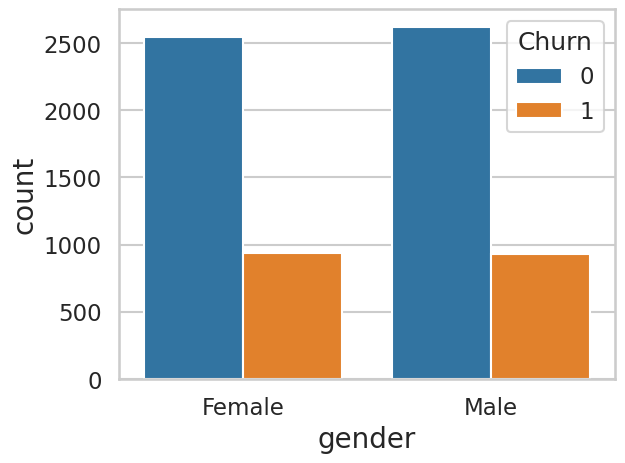

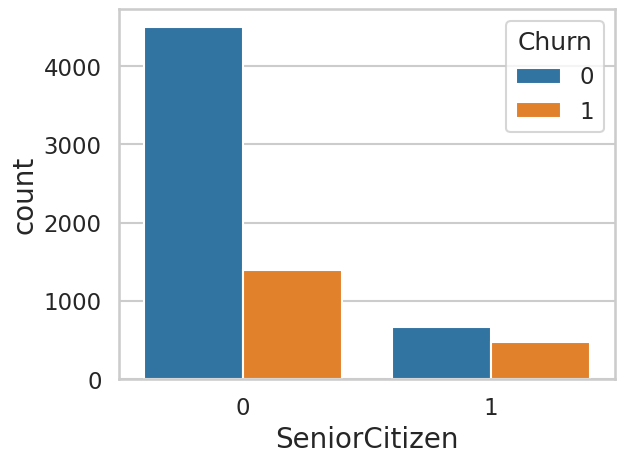

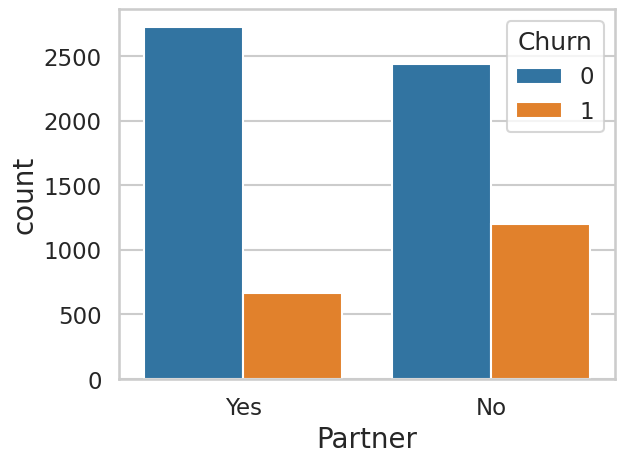

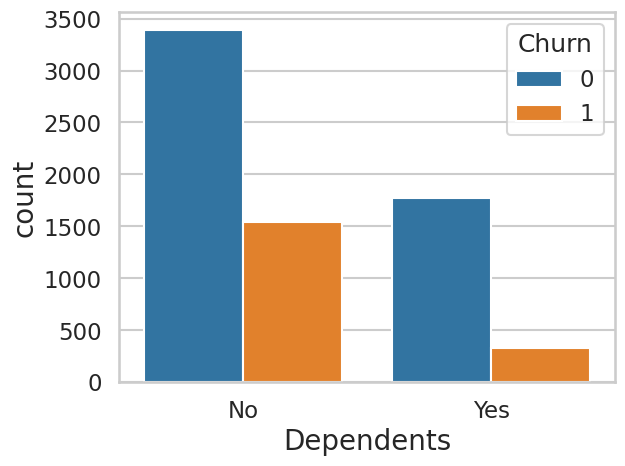

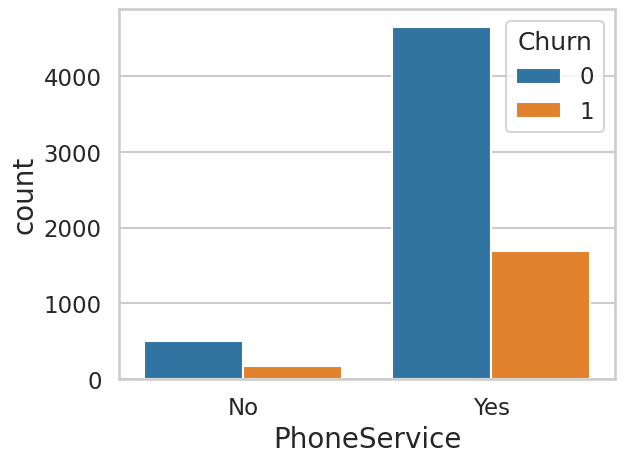

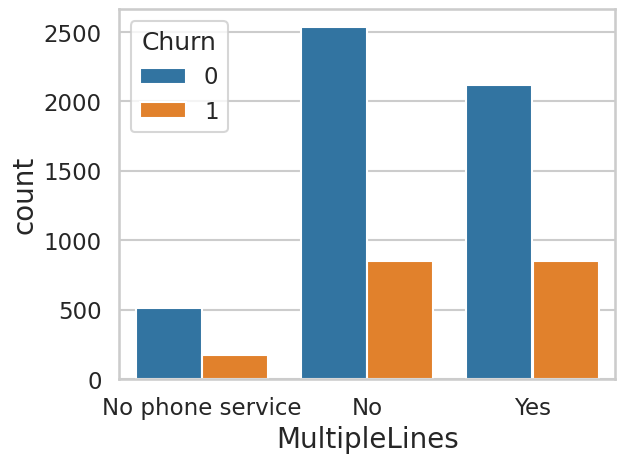

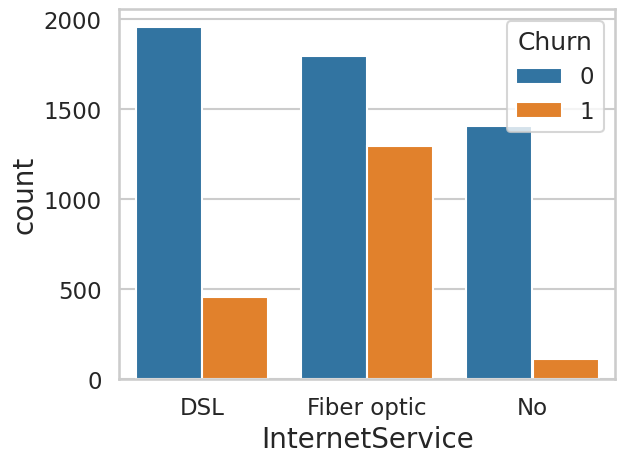

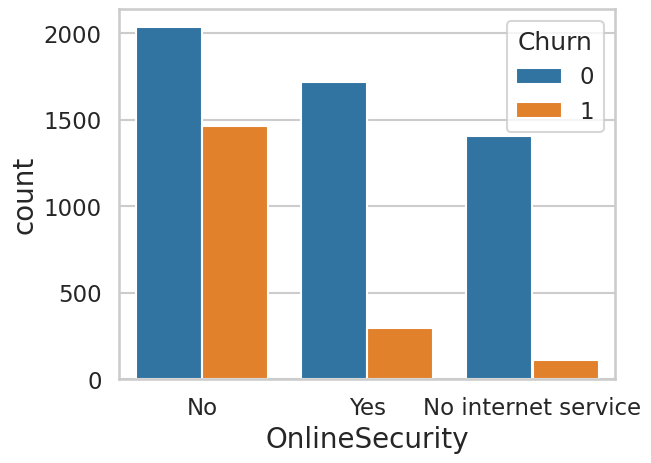

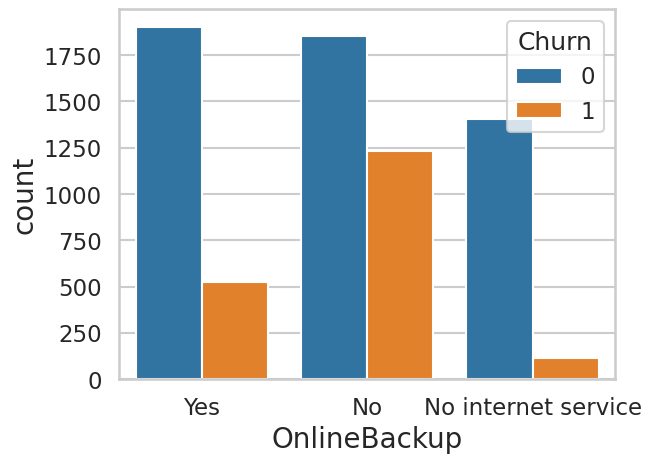

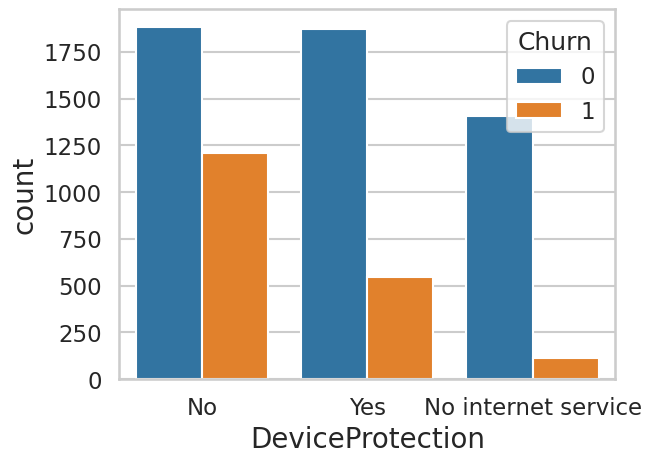

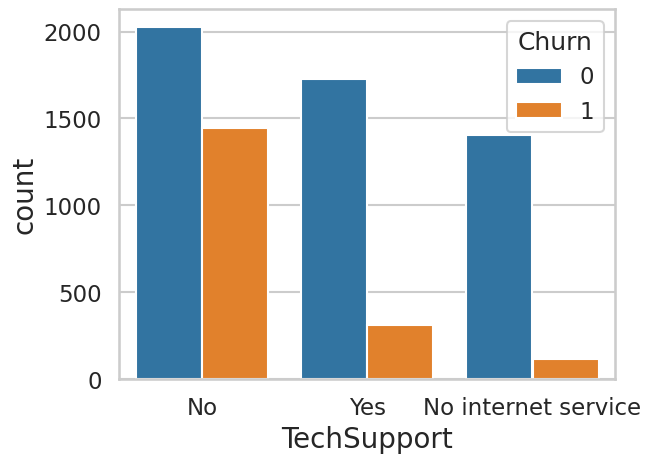

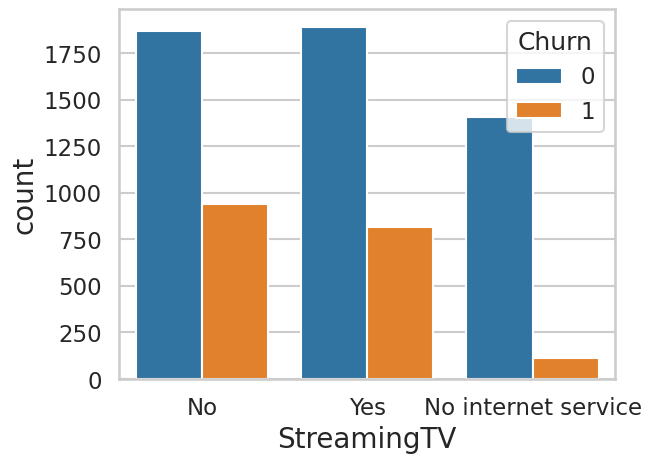

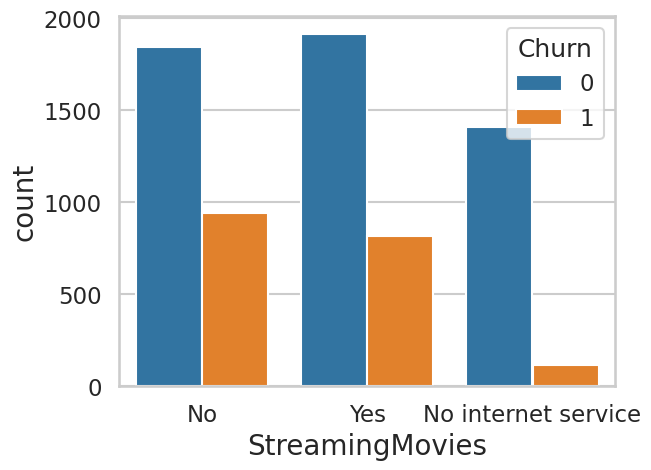

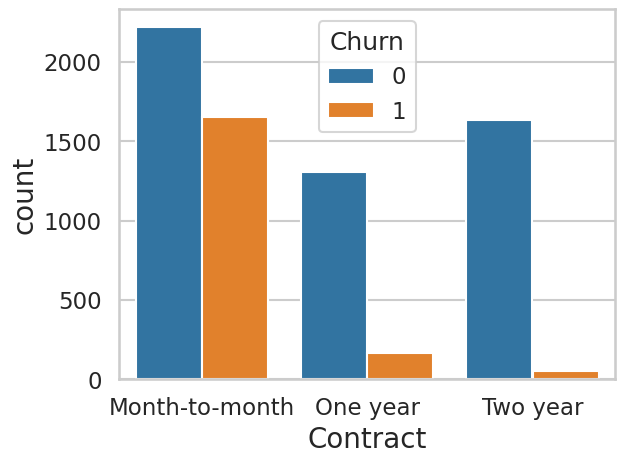

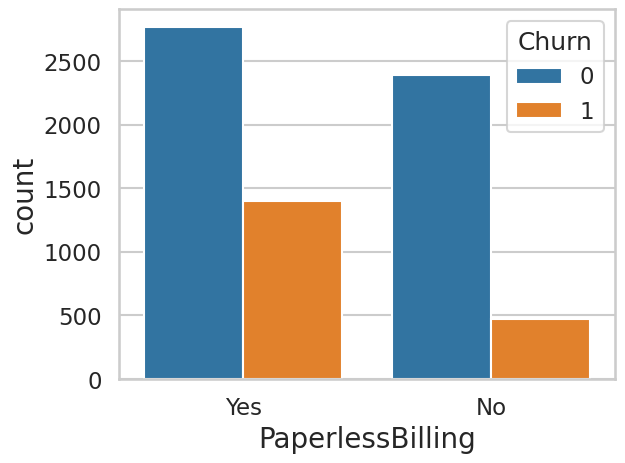

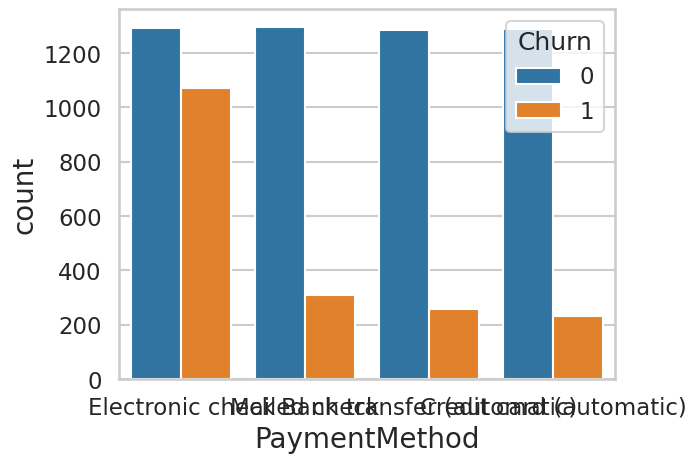

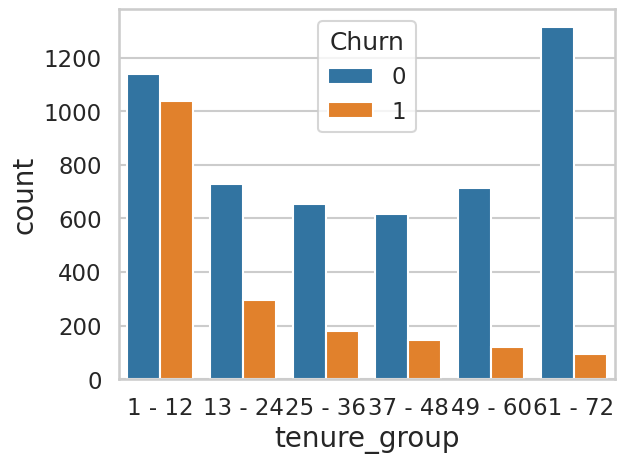

In [101]:
for i, predictor in enumerate(telco_data.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=telco_data, x=predictor, hue='Churn')

Converting the target variable 'Churn'  in a binary numeric variable i.e. Yes=1 ; No = 0

In [36]:
telco_data['Churn'] = np.where(telco_data.Churn == 'Yes',1,0)

In [37]:
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


Converting all the categorical variables into dummy variables

In [38]:
telco_data_dummies = pd.get_dummies(telco_data)
telco_data_dummies.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,True,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,1,False,True,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,0,False,True,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,1,True,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,False


Relationship between Monthly Charges and Total Charges

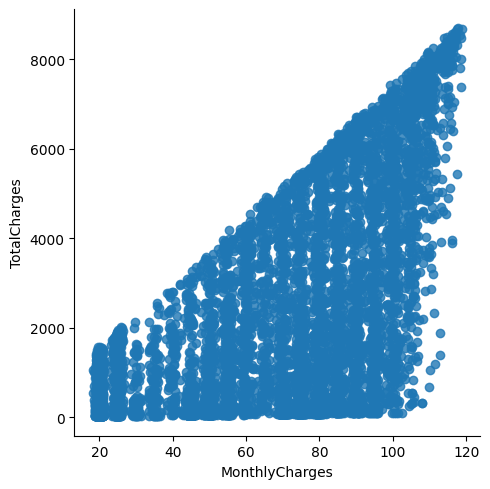

In [39]:
sns.lmplot(data=telco_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

Total Charges increase as Monthly Charges increase - as expected.

Churn by Monthly Charges and Total Charges

<ipython-input-40-940d64c03b8e>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 0) ],
<ipython-input-40-940d64c03b8e>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 1) ],


Text(0.5, 1.0, 'Monthly charges by churn')

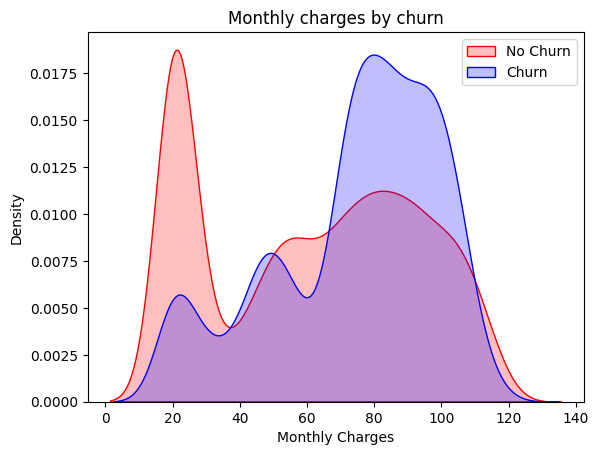

In [40]:
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

**Insight:** Churn is high when Monthly Charges ar high

<ipython-input-41-aa9d55a4850a>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0) ],
<ipython-input-41-aa9d55a4850a>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1) ],


Text(0.5, 1.0, 'Total charges by churn')

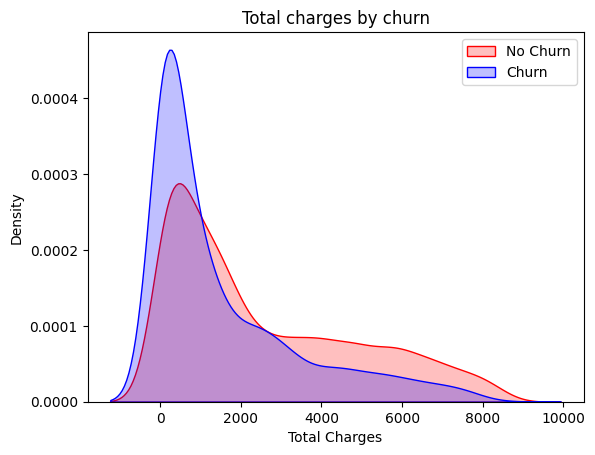

In [41]:
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

**Interesting insight ** as higher Churn at lower Total Charges

However if we combine the insights of 3 parameters i.e. Tenure, Monthly Charges & Total Charges then the picture is bit clear :- Higher Monthly Charge at lower tenure results into lower Total Charge. Hence, all these 3 factors viz **Higher Monthly Charge**,  **Lower tenure** and **Lower Total Charge** are linkd to **High Churn**.

Building a corelation of all predictors with 'Churn'

<Axes: >

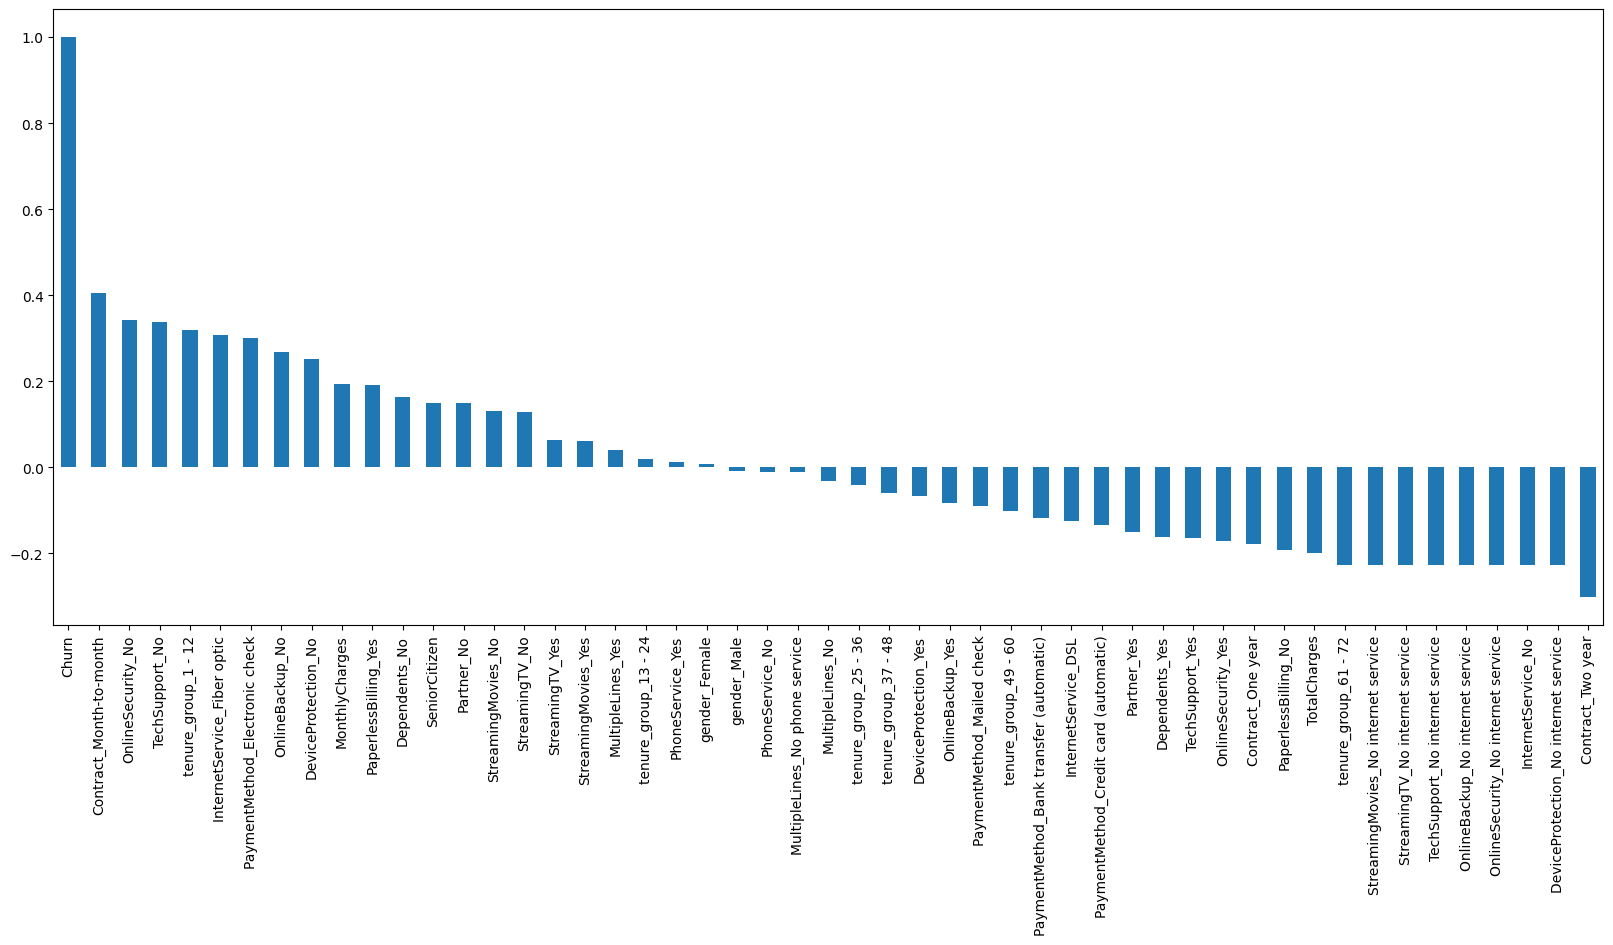

In [42]:
plt.figure(figsize=(20,8))
telco_data_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Derived Insight:

**HIGH** Churn seen in case of  **Month to month contracts**, **No online security**, **No Tech support**, **First year of subscription** and **Fibre Optics Internet**

**LOW** Churn is seens in case of **Long term contracts**, **Subscriptions without internet service** and **The customers engaged for 5+ years**

Factors like **Gender**, **Availability of PhoneService** and **# of multiple lines** have alomost **NO** impact on Churn

This is also evident from the **Heatmap** below

<Axes: >

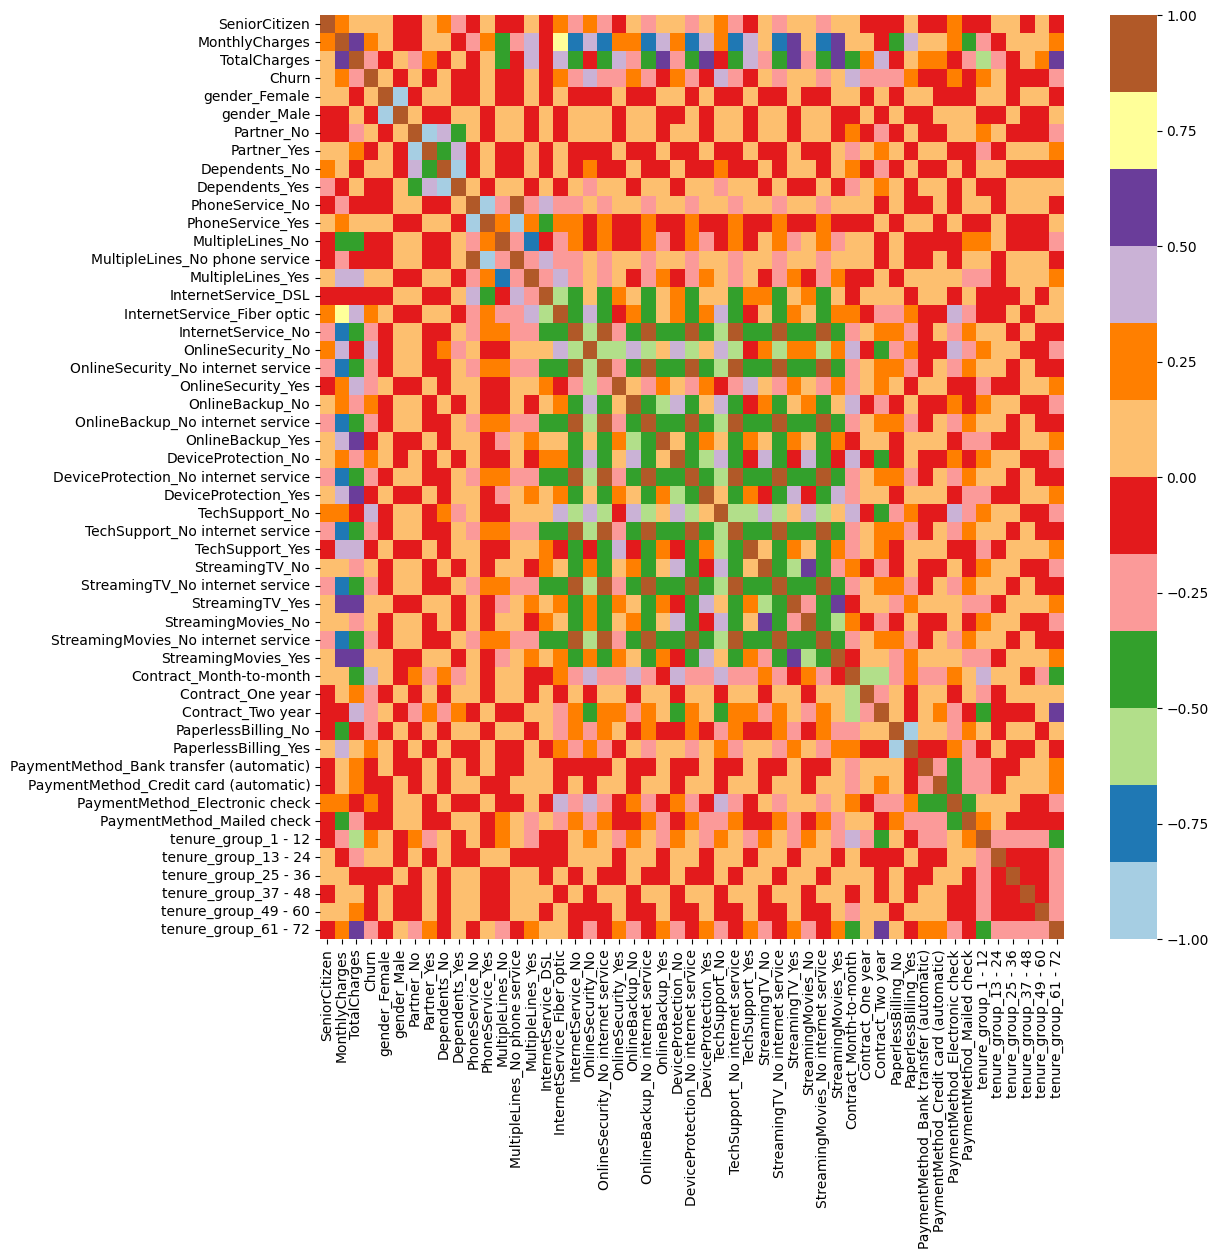

In [43]:
plt.figure(figsize=(12,12))
sns.heatmap(telco_data_dummies.corr(), cmap="Paired")

### Bivariate Analysis

In [ ]:
new_df1_target0=telco_data.loc[telco_data["Churn"]==0]
new_df1_target1=telco_data.loc[telco_data["Churn"]==1]

In [ ]:
def uniplot(df,col,title,hue =None):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright')
    plt.show()

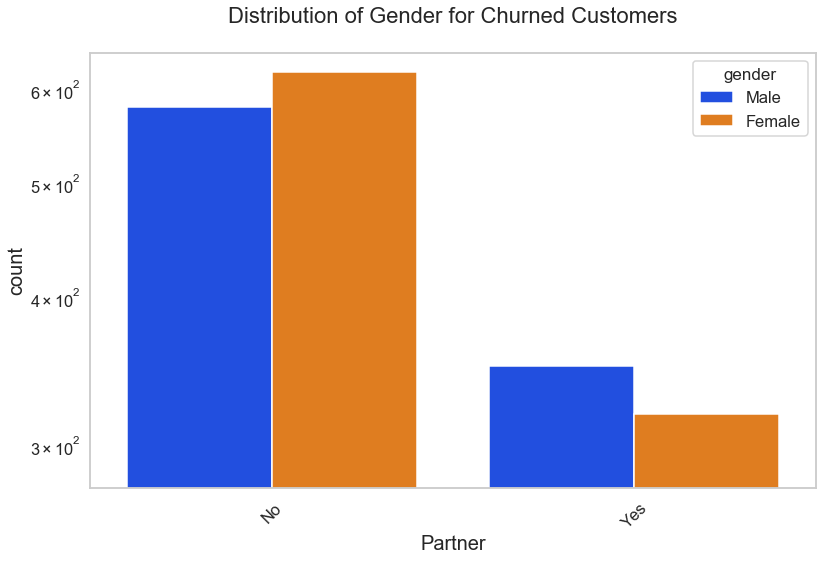

In [ ]:
uniplot(new_df1_target1,col='Partner',title='Distribution of Gender for Churned Customers',hue='gender')

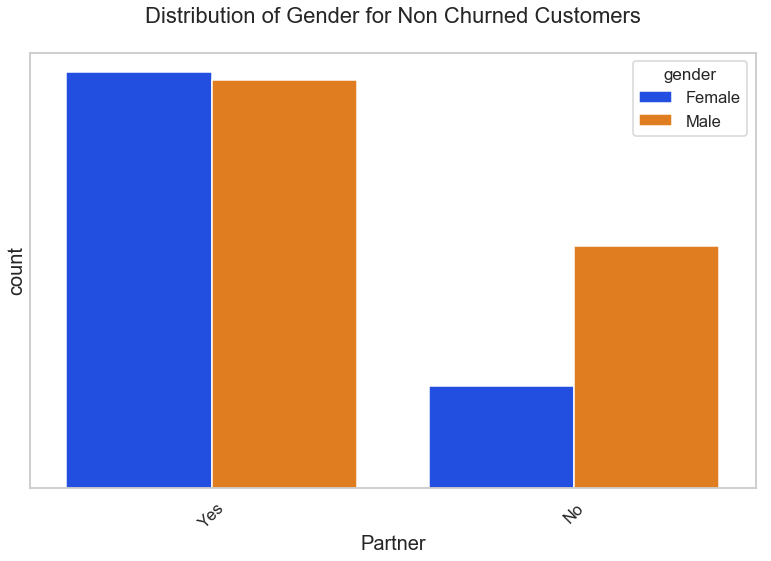

In [ ]:
uniplot(new_df1_target0,col='Partner',title='Distribution of Gender for Non Churned Customers',hue='gender')

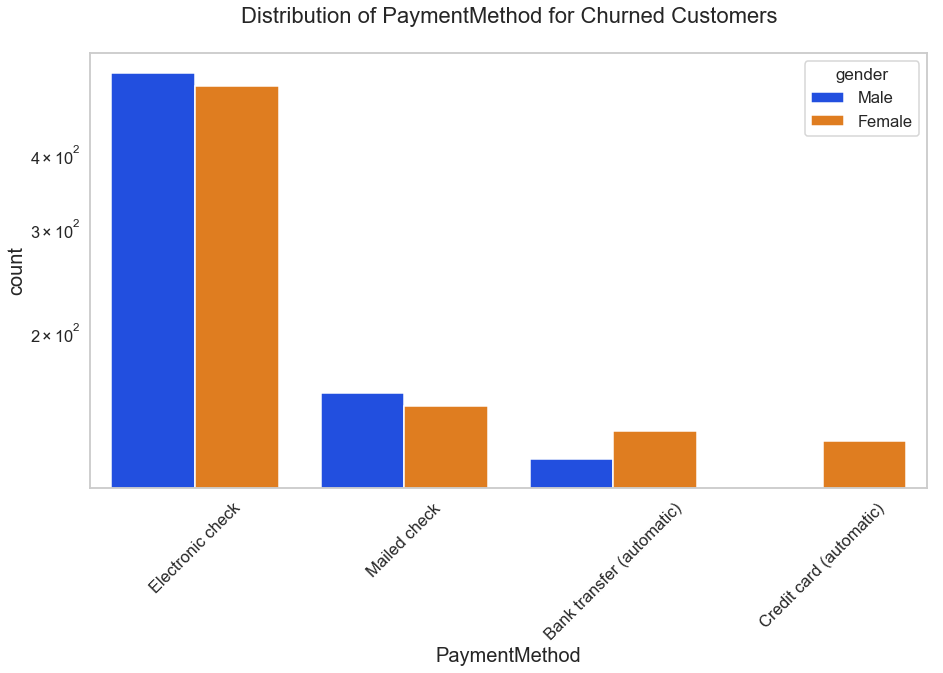

In [ ]:
uniplot(new_df1_target1,col='PaymentMethod',title='Distribution of PaymentMethod for Churned Customers',hue='gender')

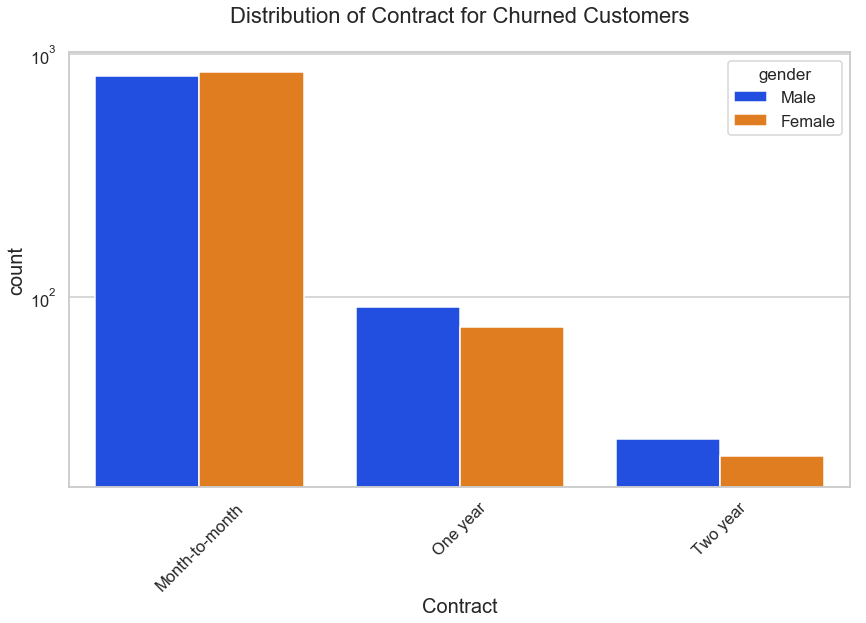

In [ ]:
uniplot(new_df1_target1,col='Contract',title='Distribution of Contract for Churned Customers',hue='gender')

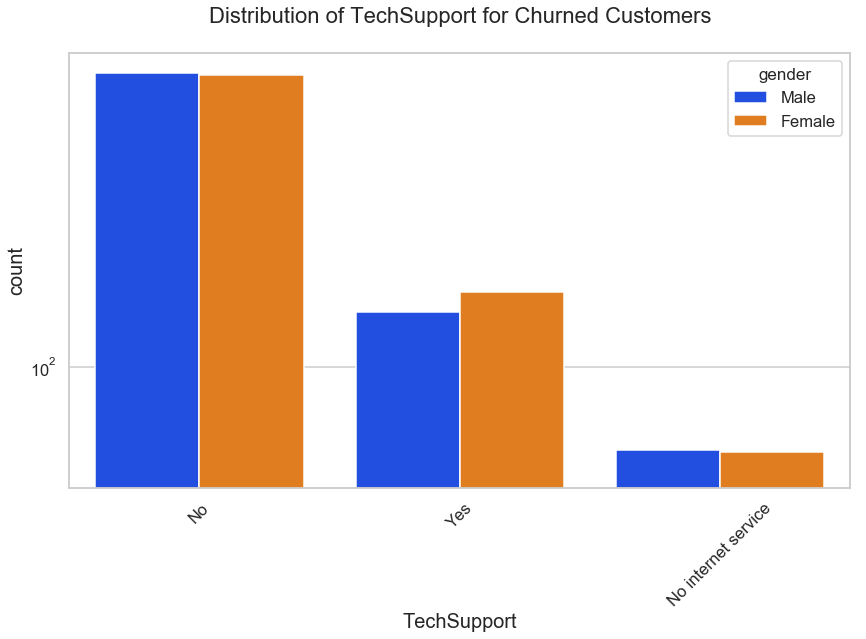

In [ ]:
uniplot(new_df1_target1,col='TechSupport',title='Distribution of TechSupport for Churned Customers',hue='gender')

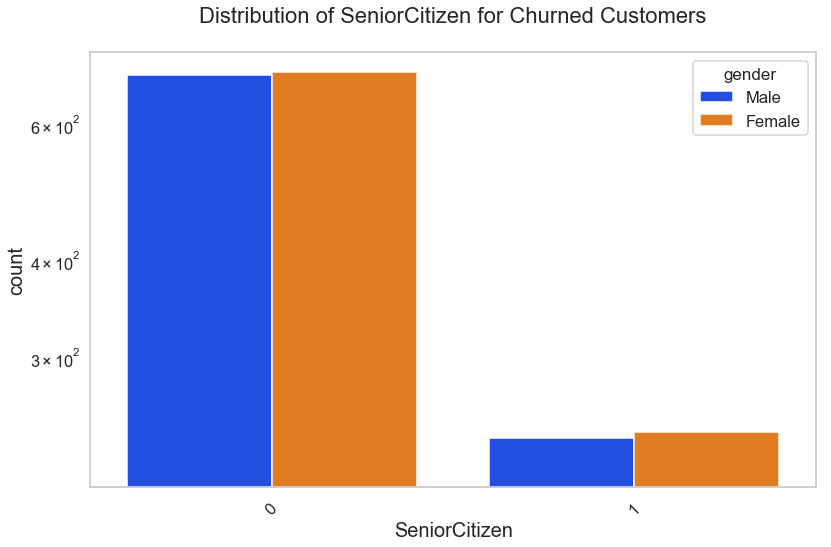

In [ ]:
uniplot(new_df1_target1,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers',hue='gender')

# CONCLUSION

These are some of the quick insights from this exercise:

1. Electronic check medium are the highest churners
2. Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.
3. No Online security, No Tech Support category are high churners
4. Non senior Citizens are high churners

Note: There could be many more such insights, so take this as an assignment and try to get more insights :)

In [52]:
telco_data_dummies.to_csv('tel_churn.csv')

#### Reading csv

In [54]:
df=pd.read_csv("tel_churn.csv")
df.head()

,Unnamed: 0,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,0,29.85,29.85,0,True,False,False,True,True,...,False,False,True,False,True,False,False,False,False,False
1,1,0,56.95,1889.50,0,False,True,True,False,True,...,False,False,False,True,False,False,True,False,False,False
2,2,0,53.85,108.15,1,False,True,True,False,True,...,False,False,False,True,True,False,False,False,False,False
3,3,0,42.30,1840.75,0,False,True,True,False,True,...,True,False,False,False,False,False,False,True,False,False
4,4,0,70.70,151.65,1,True,False,True,False,True,...,False,False,True,False,True,False,False,False,False,False


In [55]:
df=df.drop('Unnamed: 0',axis=1)

In [56]:
x=df.drop('Churn',axis=1)
x

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,True,False,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,False,True,True,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,False,True,True,False,True,False,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,True,False,True,False,True,False,False,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,84.80,1990.50,False,True,False,True,False,True,False,...,False,False,False,True,False,True,False,False,False,False
7028,0,103.20,7362.90,True,False,False,True,False,True,False,...,False,True,False,False,False,False,False,False,False,True
7029,0,29.60,346.45,True,False,False,True,False,True,True,...,False,False,True,False,True,False,False,False,False,False
7030,1,74.40,306.60,False,True,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False


In [57]:
y=df['Churn']
y

,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7027,0
7028,0
7029,0
7030,1


##### Train Test Split

In [58]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

#### Decision Tree Classifier

In [59]:
model_dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [60]:
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [61]:
y_pred=model_dt.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
model_dt.score(x_test,y_test)

0.7874911158493249

In [63]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1029
           1       0.64      0.47      0.54       378

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



As we can see that the accuracy is quite low, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.

Hence, we need to check recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low for Class 1, i.e. churned customers.

Hence, moving ahead to call SMOTEENN (UpSampling + ENN)

In [65]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x,y)

In [66]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)

In [67]:
model_dt_smote=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [68]:
model_dt_smote.fit(xr_train,yr_train)
yr_predict = model_dt_smote.predict(xr_test)
model_score_r = model_dt_smote.score(xr_test, yr_test)
print(model_score_r)
print(metrics.classification_report(yr_test, yr_predict))

0.914334181509754
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       539
           1       0.91      0.94      0.92       640

    accuracy                           0.91      1179
   macro avg       0.92      0.91      0.91      1179
weighted avg       0.91      0.91      0.91      1179



In [69]:
print(metrics.confusion_matrix(yr_test, yr_predict))

[[478  61]
 [ 40 600]]


###### Now we can see quite better results, i.e. Accuracy: 92 %, and a very good recall, precision & f1 score for minority class.

###### Let's try with some other classifier.

#### Random Forest Classifier

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
model_rf=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [72]:
model_rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [76]:
y_pred=model_rf.predict(x_test)

In [77]:
model_rf.score(x_test,y_test)

0.7917555081734187

In [78]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1029
           1       0.67      0.43      0.53       378

    accuracy                           0.79      1407
   macro avg       0.75      0.68      0.70      1407
weighted avg       0.78      0.79      0.78      1407



In [80]:
sm = SMOTEENN()
X_resampled1, y_resampled1 = sm.fit_resample(x,y)

In [81]:
xr_train1,X_test_final,yr_train1,y_test_final=train_test_split(X_resampled1, y_resampled1,test_size=0.2)

In [82]:
rf_classifier_smote=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [83]:
rf_classifier_smote.fit(xr_train1,yr_train1)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [84]:
yr_predict1 = rf_classifier_smote.predict(X_test_final)

In [85]:
rf_model_score = rf_classifier_smote.score(X_test_final, y_test_final)

In [86]:
print(rf_model_score)
print(metrics.classification_report(y_test_final, yr_predict1))

0.9434447300771208
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       511
           1       0.93      0.97      0.95       656

    accuracy                           0.94      1167
   macro avg       0.95      0.94      0.94      1167
weighted avg       0.94      0.94      0.94      1167



In [87]:
print(metrics.confusion_matrix(y_test_final, yr_predict1))

[[462  49]
 [ 17 639]]


###### With RF Classifier, also we are able to get quite good results, infact better than Decision Tree.

###### We can now further go ahead and create multiple classifiers to see how the model performance is, but that's not covered here, so you can do it by yourself :)

#### Performing PCA

In [88]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(0.9)
xr_train_pca = pca.fit_transform(xr_train1)
xr_test_pca = pca.transform(X_test_final)
explained_variance = pca.explained_variance_ratio_

In [89]:
model=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)

In [90]:
model.fit(xr_train_pca,yr_train1)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [91]:
yr_predict_pca = model.predict(xr_test_pca)

In [92]:
model_score_r_pca = model.score(xr_test_pca, y_test_final)

In [93]:
print(model_score_r_pca)
print(metrics.classification_report(y_test_final, yr_predict_pca))

0.7317909168808912
              precision    recall  f1-score   support

           0       0.74      0.60      0.66       511
           1       0.73      0.83      0.78       656

    accuracy                           0.73      1167
   macro avg       0.73      0.72      0.72      1167
weighted avg       0.73      0.73      0.73      1167



##### With PCA, we couldn't see any better results, hence let's finalise the model which was created by RF Classifier, and save the model so that we can use it in a later stage :)

#### Pickling the model

In [94]:
import pickle

In [95]:
rf_model_filename = 'model.sav'

In [96]:
pickle.dump(rf_classifier_smote, open(rf_model_filename, 'wb'))

In [97]:
load_model = pickle.load(open(rf_model_filename, 'rb'))

In [98]:
rf_model_score = load_model.score(X_test_final, y_test_final)

In [99]:
rf_model_score

0.9434447300771208

##### Our final model i.e. RF Classifier with SMOTEENN, is now ready and dumped in model.sav, which we will use and prepare API's so that we can access our model from UI.